In [17]:
# Task:
# - Segmentation: segment the 6 spheres from jaszczak_lehr_hs_130mm_nonoise[0]_final.dcm and then from jaszczak_lehr_hs_130mm_120m[0]_final.dcm.
# Info:
# - Dataset: One noisy and one normal sample. Both consist of 193 slices, and each slice is a 256 x 256 grayscale image.
# - From the noisy dataset, slice 73 was selected, while from the normal dataset, slice 75 was chosen, as these slices contained the most recognizable spheres.

In [18]:
!pip install pydicom matplotlib scikit-image numpy opencv-python scipy

In [19]:
# Imports
import os
import pydicom
import matplotlib.pyplot as plt
from skimage import io
from skimage.feature import canny
from skimage.color import gray2rgb
from skimage.segmentation import chan_vese
import numpy as np
import cv2
import sys
import scipy
from scipy.sparse.linalg import LinearOperator

In [20]:
# Load and visualize a single DICOM file. If the file contains a 3D dataset, load the specified slice.
def load_dicom(filepath, slice_index=0):
    try:
        # Load the DICOM file
        dicom_file = pydicom.dcmread(filepath)
        pixel_array = dicom_file.pixel_array

        # Check if the data is 3D
        if pixel_array.ndim == 3:
            print(f"3D DICOM file detected with shape {pixel_array.shape}.")
            print(f"Displaying slice {slice_index} of {pixel_array.shape[0]} slices.")
            slice_data = pixel_array[slice_index]
        else:
            slice_data = pixel_array

        # Display the DICOM image or slice
        plt.figure(figsize=(6, 6))
        plt.imshow(slice_data, cmap="gray")
        plt.title(f"DICOM Image: {os.path.basename(filepath)} (Slice {slice_index})")
        plt.axis("off")
        plt.show()
        return slice_data
    except Exception as e:
        print(f"Error loading DICOM file: {e}")

3D DICOM file detected with shape (193, 256, 256).
Displaying slice 73 of 193 slices.


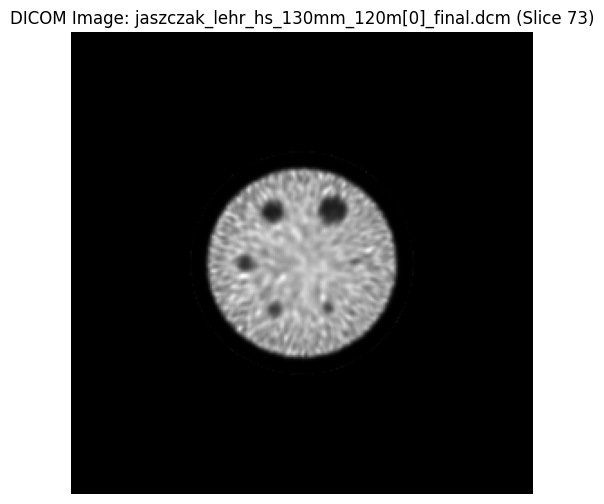

3D DICOM file detected with shape (193, 256, 256).
Displaying slice 75 of 193 slices.


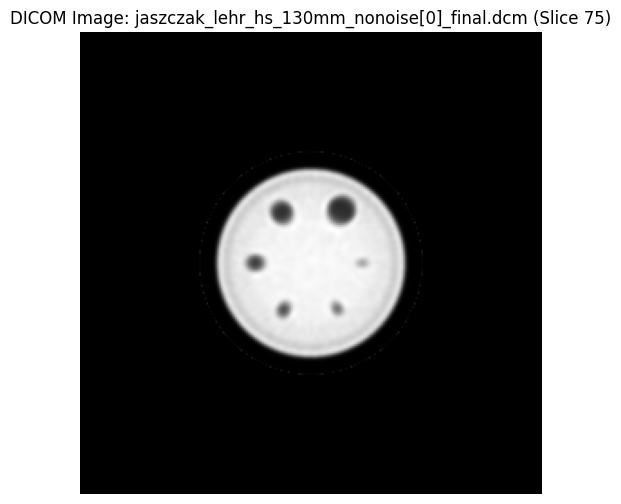

In [21]:
# Load specific slices mentioned above
dicom_noise_path = "./jaszczak_lehr_hs_130mm_120m[0]_final.dcm"
dicom_nonoise_path = "./jaszczak_lehr_hs_130mm_nonoise[0]_final.dcm"
slice_73 = load_dicom(dicom_noise_path, slice_index = 73)
slice_75 = load_dicom(dicom_nonoise_path, slice_index = 75)

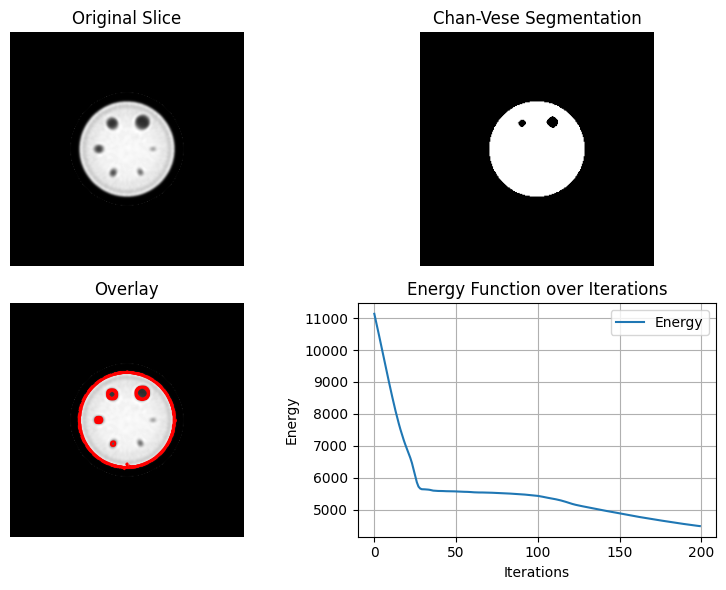

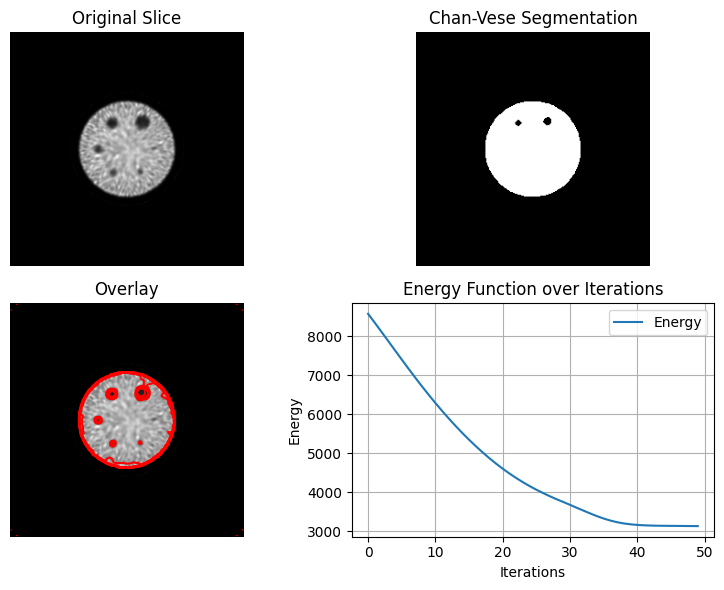

In [22]:
# Chan-Vese segmentation
def visualize_chan_vese(slice, cv_result):
  # Display results
  plt.figure(figsize=(8, 6))

  # Original slice
  plt.subplot(2, 2, 1)
  plt.imshow(slice, cmap="gray")
  plt.title(f"Original Slice")
  plt.axis("off")

  # Chan-Vese segmentation result
  plt.subplot(2, 2, 2)
  plt.imshow(cv_result[0], cmap="gray")
  plt.title("Chan-Vese Segmentation")
  plt.axis("off")

  # Overlay segmentation on the original image
  plt.subplot(2, 2, 3)
  plt.imshow(slice, cmap="gray")
  plt.contour(cv_result[1], colors='r')
  plt.title("Overlay")
  plt.axis("off")

  # Energy function over iterations
  plt.subplot(2, 2, 4)
  plt.plot(cv_result[2], label="Energy")
  plt.title("Energy Function over Iterations")
  plt.xlabel("Iterations")
  plt.ylabel("Energy")
  plt.grid(True)
  plt.legend()

  plt.tight_layout()
  plt.show()

# Apply Chan-Vese segmentation
chan_vese_nonoise = chan_vese(slice_75, mu=0.25, lambda1=1, lambda2=1, tol=0.001, max_num_iter=200, dt=0.5, init_level_set="checkerboard", extended_output=True)
chan_vese_noise = chan_vese(slice_73, mu=0.25, lambda1=1, lambda2=1, tol=0.001, max_num_iter=200, dt=0.5, init_level_set="checkerboard", extended_output=True)
visualize_chan_vese(slice_75, chan_vese_nonoise)
visualize_chan_vese(slice_73, chan_vese_noise)

In [23]:
#Jacob Gildenblat, 2015
#Implementation of edge preserving smoothing by minimizing with the Ambrosio-Tortorelli appoach
#AM scheme, using conjugate gradients
class AmbrosioTortorelliMinimizer():
	def __init__(self, img, iterations = 1, solver_maxiterations = 10, tol = 0.1, alpha = 1000, beta = 0.01, epsilon = 0.01):
		self.iterations = iterations
		self.tol = tol
		self.g = np.float64(img) / np.max(img)
		self.f = self.g
		self.edges = np.zeros(img.shape)
		self.update_gradients()
		self.alpha, self.beta, self.epsilon = alpha, beta, epsilon
		self.add_const = self.beta / (4 * self.epsilon)
		self.multiply_const = self.epsilon * self.beta
		self.maxiter = solver_maxiterations

	def update_gradients(self):
		self.grad_x, self.grad_y = self.gradients(self.f)
		self.gradient_mag = np.power(self.grad_x, 2) + np.power(self.grad_y, 2)

	def edge_linear_operator(self, input):
		v = input.reshape(*self.g.shape)
		result = np.multiply(v, self.gradient_mag * self.alpha + self.add_const) \
				- self.multiply_const* cv2.Laplacian(v, cv2.CV_64F)

		return result.reshape(*input.shape)

	def image_linear_operator(self, input):
		f = input.reshape(*self.g.shape)

		x, y = self.gradients(f)

		result = f - 2*self.alpha * (self.calc_grad_x(np.multiply(self.edges, x)) + self.calc_grad_y(np.multiply(self.edges, y)) )
		return result.reshape(*input.shape)

	def solve_edges(self):
		size = self.g.shape[0]* self.g.shape[1]
		A = LinearOperator( (size, size), matvec = self.edge_linear_operator, dtype = np.float64)
		b = np.ones(size) * self.beta / (4 * self.epsilon)

		self.edges, _ = scipy.sparse.linalg.cg(A, b, tol = self.tol, maxiter = self.maxiter)
		self.edges = np.power(self.edges.reshape(*self.g.shape), 2)
		return self.edges

	def solve_image(self):
		size = self.g.shape[0]* self.g.shape[1]
		A = LinearOperator( (size, size), matvec = self.image_linear_operator, dtype = np.float64)
		b = self.g.reshape(size)

		self.f, _ = scipy.sparse.linalg.cg(A, b, tol = self.tol, maxiter = self.maxiter)
		self.f = self.f.reshape(*self.g.shape)
		self.update_gradients()
		return self.f

	def minimize(self):
		for i in range(0, self.iterations):
			self.solve_edges()
			self.solve_image()

		self.edges = np.power(self.edges, 0.5)
		cv2.normalize(self.f, self.f ,0,255,cv2.NORM_MINMAX)
		cv2.normalize(self.edges, self.edges ,0,255,cv2.NORM_MINMAX)
		self.f = np.uint8(self.f)
		self.edges = 255 - np.uint8(self.edges)

		return self.f, self.edges

	def calc_grad_x(self, img):
		return cv2.filter2D(img, cv2.CV_64F, np.array([[-1, 0, 1]]))

	def calc_grad_y(self, img):
		return cv2.filter2D(img, cv2.CV_64F, np.array([[-1, 0, 1]]).T)

	def gradients(self, img):
		return self.calc_grad_x(img), self.calc_grad_y(img)


def show_image(image, name):
	img = image * 1
	cv2.normalize(img, img,0,255,cv2.NORM_MINMAX)
	img = np.uint8(img)
	cv2.imshow(name, img)

<ipython-input-23-ba48fe6d043c>:41: DeprecationWarning: 'scipy.sparse.linalg.cg' keyword argument `tol` is deprecated in favor of `rtol` and will be removed in SciPy v1.14.0. Until then, if set, it will override `rtol`.
  self.edges, _ = scipy.sparse.linalg.cg(A, b, tol = self.tol, maxiter = self.maxiter)
<ipython-input-23-ba48fe6d043c>:50: DeprecationWarning: 'scipy.sparse.linalg.cg' keyword argument `tol` is deprecated in favor of `rtol` and will be removed in SciPy v1.14.0. Until then, if set, it will override `rtol`.
  self.f, _ = scipy.sparse.linalg.cg(A, b, tol = self.tol, maxiter = self.maxiter)


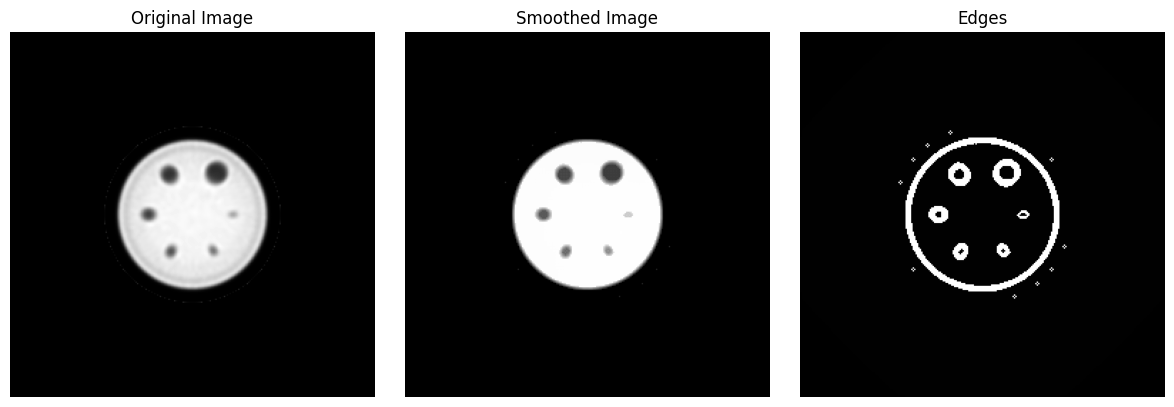

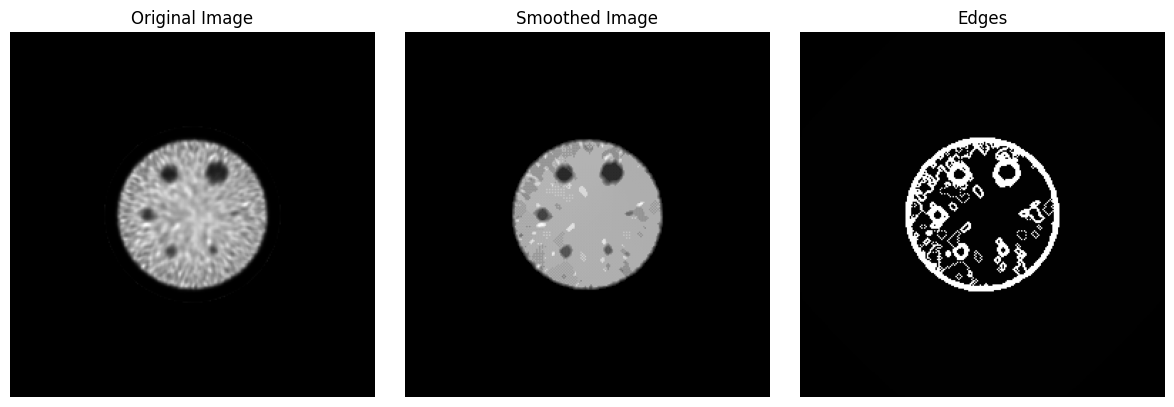

In [24]:
# Run the Ambrosio-Tortorelli minimization
def visualize_ambrosio_tortorelli(slice, smoothed_image, edges):
  # Display results
  plt.figure(figsize=(12, 4))

  # Original image
  plt.subplot(1, 3, 1)
  plt.imshow(slice, cmap="gray")
  plt.title("Original Image", fontsize=12)
  plt.axis("off")

  # Smoothed image
  plt.subplot(1, 3, 2)
  plt.imshow(smoothed_image, cmap="gray")
  plt.title("Smoothed Image", fontsize=12)
  plt.axis("off")

  # Edges
  plt.subplot(1, 3, 3)
  plt.imshow(edges, cmap="gray")
  plt.title("Edges", fontsize=12)
  plt.axis("off")

  plt.tight_layout()
  plt.show()

smoothed_image_nonoise, edges_nonoise = AmbrosioTortorelliMinimizer(slice_75, iterations=50, solver_maxiterations=50, tol=1e-5, alpha=1000, beta=0.01, epsilon=0.01).minimize()
smoothed_image_noise, edges_noise = AmbrosioTortorelliMinimizer(slice_73, iterations=50, solver_maxiterations=50, tol=1e-5, alpha=1000, beta=0.01, epsilon=0.01).minimize()
visualize_ambrosio_tortorelli(slice_75, smoothed_image_nonoise, edges_nonoise)
visualize_ambrosio_tortorelli(slice_73, smoothed_image_noise, edges_noise)

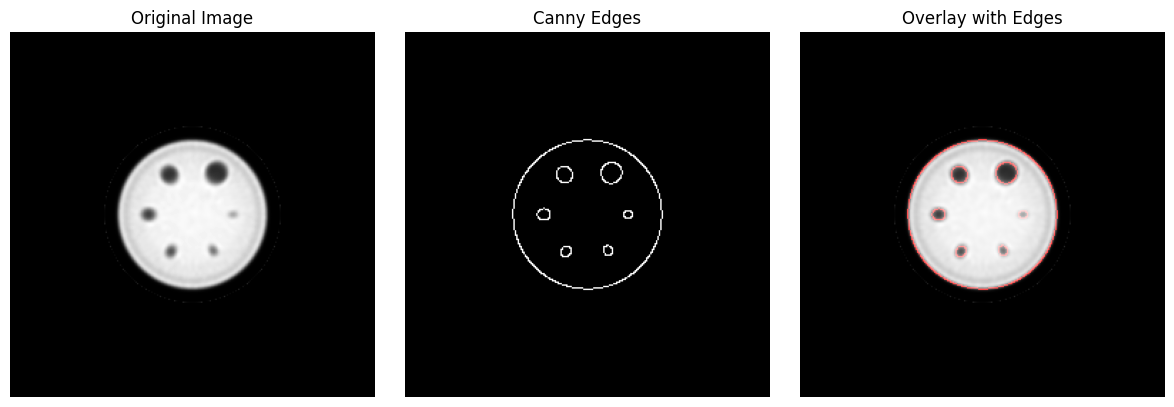

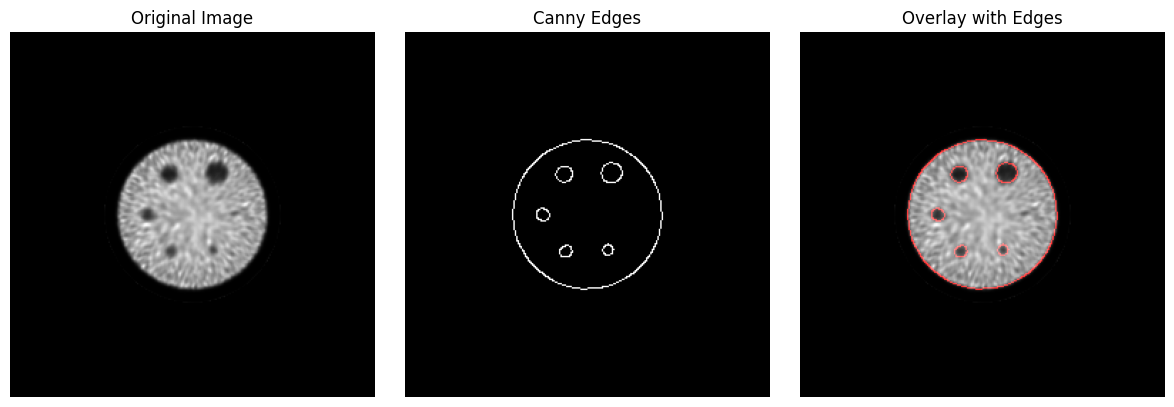

In [25]:
# Canny edge detection
# Canny edge detection visualization
def visualize_canny(slice, edges):
    rgb_image = gray2rgb(slice / slice.max())  # Normalize for RGB scaling
    combined = rgb_image.copy()
    combined[edges, 0] = 1.0  # Set red channel to max where edges are detected

    # Display results
    plt.figure(figsize=(12, 4))

    # Original slice
    plt.subplot(1, 3, 1)
    plt.imshow(slice, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    # Canny edge map
    plt.subplot(1, 3, 2)
    plt.imshow(edges, cmap="gray")
    plt.title("Canny Edges")
    plt.axis("off")

    # Overlay Canny edges on the original image
    plt.subplot(1, 3, 3)
    plt.imshow(combined)
    plt.title("Overlay with Edges")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Apply Canny edge detection
canny_edges_nonoise = canny(slice_75, sigma=2.0)
canny_edges_noise = canny(slice_73, sigma=3.0)

# Visualize results
visualize_canny(slice_75, canny_edges_nonoise)
visualize_canny(slice_73, canny_edges_noise)